In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import GPy, patsy, pickle

In [3]:
data = pd.read_csv("data/tidy_normalize_all.csv",index_col=None)
data = data[(data.standard==1) | data.paraquat==1]

In [4]:
skip_strains = ['ura3_EV', u'cspD1_EV', u'cspD1_cspD1','ura3']

In [5]:
g = data.groupby('Strain')

In [6]:
ura3 = g.get_group('ura3')
g_ura3 = ura3.groupby(['Experiment','Well'])

In [7]:
def plot_model(x,gp,strain):
    time = np.linspace(-1,41)
    
    plt.subplot(121)
    
    predx = patsy.build_design_matrices([x.design_info],{'time':time,'Strain':['ura3']*50,'paraquat':[0]*50})[0]
    mu,var = gp.predict(predx[:,1:])
    mu = mu[:,0]
    var = var[:,0]

    plt.plot(time,mu,color='k')
    plt.fill_between(time,mu-2*np.sqrt(var),mu+2*np.sqrt(var),color='k',alpha=.2)
    
    predx = patsy.build_design_matrices([x.design_info],{'time':time,'Strain':['ura3']*50,'paraquat':[1]*50})[0]
    mu,var = gp.predict(predx[:,1:])
    mu = mu[:,0]
    var = var[:,0]

    plt.plot(time,mu,color='g')
    plt.fill_between(time,mu-2*np.sqrt(var),mu+2*np.sqrt(var),color='g',alpha=.2)    
    
    plt.subplot(122)
    predx = patsy.build_design_matrices([x.design_info],{'time':time,'Strain':[strain]*50,'paraquat':[0]*50})[0]
    mu,var = gp.predict(predx[:,1:])
    mu = mu[:,0]
    var = var[:,0]

    plt.plot(time,mu,color='k')
    plt.fill_between(time,mu-2*np.sqrt(var),mu+2*np.sqrt(var),alpha=.2,color='k')
    
    predx = patsy.build_design_matrices([x.design_info],{'time':time,'Strain':[strain]*50,'paraquat':[1]*50})[0]
    mu,var = gp.predict(predx[:,1:])
    mu = mu[:,0]
    var = var[:,0]

    plt.plot(time,mu,color='g')
    plt.fill_between(time,mu-2*np.sqrt(var),mu+2*np.sqrt(var),color='g',alpha=.2)

In [8]:
def plot_wells(data,c,alpha):
    g2 = data.groupby(['Experiment','Well'])

    for ind,x in g2:
        x.sort_values('time',inplace=True)
        plt.plot(x.time,x.OD,c,alpha=alpha)

In [9]:
def plot_data(data,strain):
    g = data.groupby(["Strain",'paraquat'])
    
    #ylim = (np.round(temp.OD.min() - .5,1),np.round(temp.OD.max() + .5,1))
       
    plt.subplot(121)
    
    temp = g.get_group(('ura3',0))
    plot_wells(temp,'k',.1)
    
    temp = g.get_group(('ura3',1))
    plot_wells(temp,'g',.1)
    
    plt.ylabel("log(OD)",fontsize=30)
    plt.xlabel("time (h)",fontsize=30)
    plt.yticks(fontsize=25)
    plt.xticks(fontsize=25)
    plt.grid(True,color='grey')
    plt.xlim(-2,44)
    
    
    plt.subplot(122)
    
    temp = g.get_group((strain,0))
    plot_wells(temp,'k',.1)
    
    temp = g.get_group((strain,1))
    plot_wells(temp,'g',.1)
    
    plt.xlabel("time (h)",fontsize=30)
    plt.yticks(fontsize=25)
    plt.xticks(fontsize=25)
    plt.grid(True,color='grey')
    plt.xlim(-2,44)


In [32]:
ind = ['strain','BF','BF-permuted']
table = pd.DataFrame(columns=ind)

In [33]:
permutations = True # should we calculate the permutations?
save = True # should we save results?
_pickle = False
plot = True

for strain,temp in g:
    
    if strain in skip_strains:
        continue
        
    row = pd.Series(index=ind)
    row['strain'] = strain
    
    # add parent strain data
    temp_full = temp.append(ura3)
    
    select = temp_full.time.isin(np.arange(0,43,8))
    temp = temp_full[select]

    y,x = patsy.dmatrices('OD ~ scale(time) + C(Strain) + C(paraquat)',temp)
    
    print strain,temp.shape, temp.time.unique().shape
    
    gp = GPy.models.GPRegression(x[:,1:],y,GPy.kern.RBF(3,ARD=True))
    gp.optimize()
    
    if plot:
        plt.figure(figsize=(12,6))
        plot_model(x,gp,strain)
        plot_data(temp_full,strain)
        
        ylim = (temp.OD.min(),temp.OD.max())
        
        plt.subplot(121)
        plt.title("$\Delta ura3$",fontsize=40)
        plt.ylim(ylim)
        plt.subplot(122)
        plt.title("$\Delta %s$"%strain,fontsize=40)
        plt.ylim(ylim)
        plt.tight_layout()
        plt.savefig("figures/paraquat/%s.png"%strain,bbox_inches="tight",dpi=300)    
        plt.close()
    
    gp_null = GPy.models.GPRegression(x[:,2:],y,GPy.kern.RBF(2,ARD=True))
    gp_null.optimize()
    
    row.BF = gp.log_likelihood() - gp_null.log_likelihood()
    
    if _pickle:
        pickle.dump(gp,open('pickle/paraquat/%s.gp.pickle'%strain,'w'))
    
    del gp
    
    if permutations:
    
        perms = []
        for i in range(50):
            if i%10 == 0:
                print i

            x[:,1] = np.random.choice(x[:,1],x.shape[0],replace=False)
            gp = GPy.models.GPRegression(x[:,1:],y,GPy.kern.RBF(3,ARD=True))
            gp.optimize()

            perms.append(gp.log_likelihood() - gp_null.log_likelihood())

            del gp

        row['BF-permuted'] = perms

    del gp_null
        
    if save:
        table = table.append(row,ignore_index=True)
        table.index = range(table.shape[0])
        table.to_csv("paraquat_bfs.csv")
        

VNG0039 (1656, 12) (6,)


 /home/ptonner/dev/hsalinarum_tf_phenotype/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0
10
20
30
40
VNG0194H (1656, 12) (6,)
0
10
20
30
40
VNG0471 (1656, 12) (6,)
0
10
20
30
40
VNG1029 (1656, 12) (6,)
0
10
20
30
40
VNG2268 (1656, 12) (6,)
0
10
20
30
40
VNG2614 (1656, 12) (6,)
0
10
20
30
40
arcR (1656, 12) (6,)
0
10
20
30
40
asnC (1656, 12) (6,)
0
10
20
30
40
birA (1656, 12) (6,)
0
10
20
30
40
copR (1800, 12) (6,)
0
10
20
30
40
cspD1 (1656, 12) (6,)
0
10
20
30
40
cspD2 (1656, 12) (6,)
0
10
20
30
40
hlx1 (1728, 12) (6,)
0
10
20
30
40
hlx2 (1656, 12) (6,)
0
10
20
30
40
hrg (1656, 12) (6,)
0
10
20
30
40
idr1 (1656, 12) (6,)
0
10
20
30
40
idr2 (1656, 12) (6,)
0
10
20
30
40
kaiC (1656, 12) (6,)
0
10
20
30
40
phoU (1656, 12) (6,)
0
10
20
30
40
prp2 (1656, 12) (6,)
0
10
20
30
40
rosR (1656, 12) (6,)
0
10
20
30
40
sirR (1656, 12) (6,)
0
10
20
30
40
trh2 (1656, 12) (6,)
0
10
20
30
40
trh3 (1656, 12) (6,)
0
10
20
30
40
trh4 (1656, 12) (6,)
0
10
20
30
40
trmB (1656, 12) (6,)
0
10
20
30
40
troR (1656, 12) (6,)
0
10
20
30
40


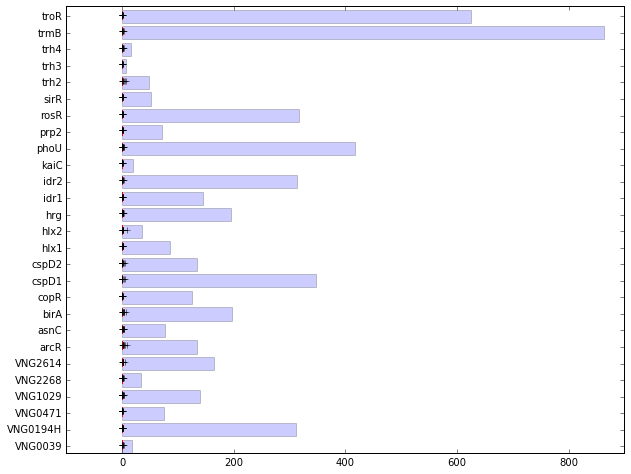

In [40]:
plt.figure(figsize=(10,8))

plt.barh(range(table.shape[0]),table.BF,alpha=.2)
plt.boxplot([p for p in table['BF-permuted']],positions=np.arange(.5,table.shape[0]+.5,1),vert=False);
plt.yticks(np.arange(table.shape[0])+.4,table.strain);

# plt.xlim(-1,50)

In [46]:
for i,r in table.iterrows():
    print sum(r.BF<np.array(r['BF-permuted']))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [45]:
r['BF-permuted']

[0.082504662462611122,
 -4.6039672270126175e-06,
 -3.2391426884714747e-05,
 -1.2161042150182766e-05,
 1.8728173869867533,
 -1.7088803019760235e-05,
 -7.3802846145554213e-06,
 -8.9140314003088861e-05,
 0.69434248241066143,
 0.21017984356763009,
 -4.1756800328585086e-06,
 -1.4449614468503569e-05,
 -0.00051016659426750266,
 0.21934649070135492,
 -4.3436444343569747e-05,
 0.13841656257613977,
 0.079015471088268896,
 1.7628119307172483,
 -9.5282596703327727e-05,
 0.19821047873870157,
 0.6567639918275745,
 -7.7821667446187348e-05,
 -1.4404700550585403e-05,
 0.0031248936969632268,
 -5.6074017038554302e-06,
 -8.1522933783162443e-05,
 0.01289995929869292,
 -2.4314171014339081e-05,
 -2.4927832214416412e-05,
 -9.0136699100185069e-06,
 5.4732920489186654e-06,
 -2.6028381171272486e-05,
 -1.1383433957234956e-05,
 -0.00035558744309582835,
 -0.0015468677670469333,
 -6.6153404532087734e-06,
 -3.0810065709374612e-05,
 -1.4058162832952803e-05,
 0.015675375907221678,
 0.026802233727721614,
 -0.00454684964

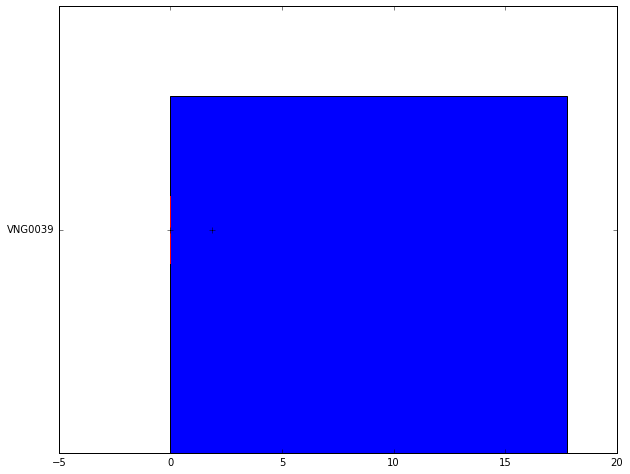

In [30]:
plt.figure(figsize=(10,8))

plt.barh(range(table.shape[0]),table.BF)
plt.boxplot([p for p in table['BF-permuted']],positions=np.arange(.5,table.shape[0]+.5,1),vert=False);
plt.yticks(np.arange(.5,.5+table.shape[0]),table.strain);

# plt.xlim(-1,50)

In [31]:
table

,strain,BF,BF-permuted
0,VNG0039,17.783874,"[1.85926376356, -9.61472511563e-05, -6.1189583..."


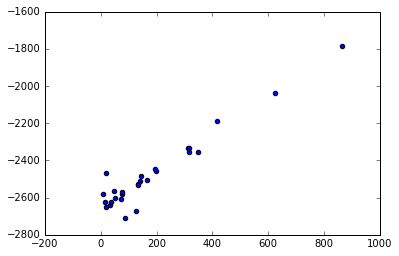

In [21]:
plt.scatter(table.BF,[np.mean(p) for p in table['BF-permuted']])

In [19]:
gp = GPy.models.GPRegression(x[:,1:],y,GPy.kern.RBF(2,ARD=True))
gp.optimize()

In [20]:
gp.le

GP_regression.,value,constraints,priors
rbf.variance,0.988175793111,+ve,
rbf.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,0.419296446039,+ve,


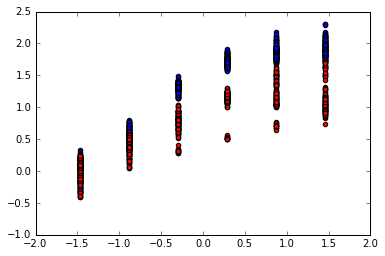

In [27]:
select = x[:,2] == 0
plt.scatter(x[:,3][select],y[select])

select = x[:,2] == 1
plt.scatter(x[:,3][select],y[select],c='r')

In [26]:
x

DesignMatrix with shape (1656, 4)
  Intercept  C(Strain)[T.ura3]  C(paraquat)[T.1]  scale(time)
          1                  1                 0     -1.46385
          1                  1                 0     -0.87831
          1                  1                 0     -0.29277
          1                  1                 0      0.29277
          1                  0                 0      0.87831
          1                  1                 0      1.46385
          1                  1                 0     -1.46385
          1                  1                 0     -0.87831
          1                  1                 0     -0.29277
          1                  1                 0      0.29277
          1                  1                 0      0.87831
          1                  1                 0      1.46385
          1                  1                 0     -1.46385
          1                  1                 0     -0.87831
          1                  1      